In [4]:
import json
import numpy as np
import pandas as pd
import h5py
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import random

In [5]:
data_dir = Path('../../data')
cello_dir = data_dir / f'CellO_data/bulk_RNA_seq_training_set'

## The goal of this project is to find B vectors(embedding) having trained Z matrix and observation data
### First let's try to find back the random set of B vectors

### Loading Y and Z and verifying we've got the right vectors
#### Y is a source data used for PLIER training. Y ≈ ZB

In [6]:
# transposing, so we have columns as features and rows as sample vectors
full_Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
full_Y_df.shape

(4293, 55904)

In [7]:
with open(cello_dir / 'experiment_to_study.json', 'r') as f:
    exp2study = json.load(f)
full_df_studies = full_Y_df.index.map(exp2study)

In [8]:
train_studies = open(cello_dir / 'plier_train_studies.txt').read().strip().split(',')
len(train_studies)

237

In [9]:
train_Y_df = full_Y_df[full_df_studies.isin(train_studies)]
test_Y_df = full_Y_df[~full_df_studies.isin(train_studies)]
train_Y_df.shape, test_Y_df.shape

((3868, 55904), (425, 55904))

In [10]:
Z_df = pd.read_csv(data_dir / 'plierResult-train/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 356)

#### Not all genes from original data(Y) present in Z matrix. Rest of the genes were droped by PLIER as less insignificant
Let's select only 5900 genes that present in matrix Z. Z is a vertical matrix with columns matching the dimensionality of our embedding vector and number of rows matching the number of genes used

In [11]:
Z_genes = Z_df.index
train_Y_df = train_Y_df[Z_genes]
test_Y_df = test_Y_df[Z_genes]

train_Y_df.shape

(3868, 5900)

#### Loading B matrix and sample some random vectors that we want to find back

In [12]:
# transposing, so we have columns as features and rows as sample vectors
B_df = pd.read_csv(data_dir / 'plierResult-train/B.csv').transpose()
B_df.shape

(3868, 356)

Making sure we've trained PLIER on train set

In [13]:
B_samples = B_df.index.values
train_samples = train_Y_df.index.values
assert set(B_samples) == set(train_samples)
assert sum(B_samples != train_samples) == 0

In [14]:
# store samples associated with target embeddings
target_y_vectors = test_Y_df.values

# computing normalization values on train dataset
per_gene_mean = train_Y_df.mean().values
per_gene_std = train_Y_df.std().values

target_y_vectors = (target_y_vectors - per_gene_mean) / per_gene_std

target_y_vectors.shape

(425, 5900)

## Using regression to find the B that will produce vector close to test Y

In [15]:
from numpy.linalg import inv

In [16]:
X = Z_mat

# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b_test = inv(X.T.dot(X)).dot(X.T).dot(target_y_vectors.T)
b_test.shape

(356, 425)

#### Let's try to compare source Y vales to values reconstructed using Z and reconstructed B

In [17]:
y_test_hat = Z_mat.dot(b_test).transpose()
y_test_hat.shape

(425, 5900)

<AxesSubplot:>

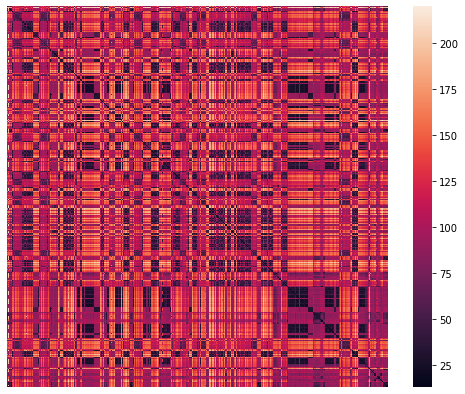

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(target_y_vectors, y_test_hat)
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### Using Pearson correlation as a distance

In [20]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [21]:
y2y_hat_dists = pearson_dists(target_y_vectors, y_test_hat)
y2y_random_dists = pearson_dists(
    target_y_vectors, 
    random.sample(target_y_vectors.tolist(), len(target_y_vectors))
)

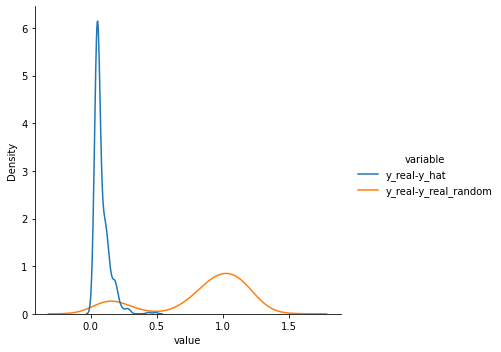

In [22]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists,
    'y_real-y_real_random': y2y_random_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=['y_real-y_hat', 'y_real-y_real_random']), 
    x='value', hue='variable', kind='kde')

### Existing Z matrix does great job embedding the test data

## Looking at closest samples

In [23]:
import sys
sys.path.append('../../onto_lib')

In [24]:
from anndata import AnnData
import scanpy as sc
import json
import general_ontology_tools as got

In [28]:
with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

In [101]:
sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}

In [102]:
subset_size = 5

test_b_vectors = b_test.T
test_samples = test_Y_df.index.values

random_test_inds = random.choices(range(len(test_b_vectors)), k=subset_size)
random_test_embeddings = test_b_vectors[random_test_inds]
random_test_samples = test_samples[random_test_inds]

### Compute disstance between the test sample embedding and all train examples

In [103]:
B_mat = B_df.values
B_mat.shape

(3868, 356)

In [104]:
test_b_to_train_samples_dists = B_mat.dot(random_test_embeddings.T)
test_b_to_train_samples_dists.shape

(3868, 5)

In [105]:
dists_df = pd.DataFrame(test_b_to_train_samples_dists)
dists_df.columns = random_test_samples
dists_df.index = train_samples
dists_df.head()

SRX765935  SRX867140  SRX1054522  SRX977781  SRX475249
SRX890545   -0.964867  -2.928471   -0.706159   2.174436  -1.297604
SRX1067711  -0.314586  -2.323228   -1.013031   1.253748  -1.436774
SRX1067710   0.641204  -1.581563   -1.122604   0.229651  -1.384191
SRX762971    1.522846   1.618509   -1.177389   6.608359  -2.674729
SRX762970    1.234952   2.468526   -0.967188   6.876149  -2.524836

In [106]:
n_closest = 2

for test_sample in random_test_samples:
    print(f'test sample: {test_sample}. cell types: {sample2types[test_sample]}')
    print(f'{n_closest} closest train samples:')
    
    closest = dists_df[test_sample].nsmallest(n_closest).index.values
    for c in closest:
        print(f'\t train sample: {c}. cell types: {sample2types[c]}')

    print('---\n')

test sample: SRX765935. cell types: ['bone marrow cell', 'bone marrow hematopoietic cell', 'hematopoietic precursor cell', 'bone cell', 'cell', 'precursor cell', 'hematopoietic cell', 'animal cell', 'eukaryotic cell', 'somatic cell', 'native cell']
2 closest train samples:
	 train sample: SRX1303812. cell types: ['cell', 'neural cell', 'central nervous system neuron', 'CNS neuron (sensu Vertebrata)', 'animal cell', 'neuron', 'eukaryotic cell', 'electrically active cell', 'electrically signaling cell', 'somatic cell', 'electrically responsive cell', 'native cell']
	 train sample: SRX656156. cell types: ['nucleate cell', 'cell', 'leukocyte', 'blood cell', 'hematopoietic cell', 'myeloid leukocyte', 'animal cell', 'stuff accumulating cell', 'granulocyte', 'eukaryotic cell', 'defensive cell', 'phagocyte', 'mature neutrophil', 'myeloid cell', 'somatic cell', 'neutrophil', 'native cell', 'motile cell']
---

test sample: SRX867140. cell types: ['male gamete', 'ciliated cell', 'cell', 'eukaryot

### Plotting

In [107]:
b_test_df = pd.DataFrame(test_b_vectors)
b_test_df.index = test_samples
b_test_df.columns = B_df.columns
b_test_df.shape

(425, 356)

In [108]:
B_full = pd.concat([B_df, b_test_df])
B_full.shape

(4293, 356)

In [109]:
ad = AnnData(B_full)

In [122]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_per_b_samples = B_full.index.map(sample2types).values

# pd.DataFrame(mlb.fit_transform(s)
             
# B_full_ctypes = B_full.index.map(sample2types)
types_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_full.index)
types_dummies.shape

(4293, 317)

In [123]:
types_dummies

B cell  Bm4 B cell  CD14-low, CD16-positive monocyte  \
SRX890545        0           0                                 0   
SRX1067711       0           0                                 0   
SRX1067710       0           0                                 0   
SRX762971        0           0                                 0   
SRX762970        0           0                                 0   
...            ...         ...                               ...   
SRX1433438       0           0                                 0   
SRX1433437       0           0                                 0   
SRX1433436       0           0                                 0   
SRX1433435       0           0                                 0   
SRX1433439       0           0                                 0   

            CD14-positive monocyte  \
SRX890545                        1   
SRX1067711                       0   
SRX1067710                       0   
SRX762971                        0   
SRX762970                        0   
...                            ...   
SRX1433438                       0   
SRX1433437                       0   
SRX1433436                       0   
SRX1433435                       0   
SRX1433439                       0   

            CD14-positive, CD16-negative classical monocyte  \
SRX890545                                                 0   
SRX1067711                                                0   
SRX1067710                                                0   
SRX762971                                                 0   
SRX762970                                                 0   
...                                                     ...   
SRX1433438                                                0   
SRX1433437                                                0   
SRX1433436                                                0   
SRX1433435                                                0   
SRX1433439                                                0   

            CD14-positive, CD16-positive monocyte  \
SRX890545                                       0   
SRX1067711                                      0   
SRX1067710                                      0   
SRX762971                                       0   
SRX762970                                       0   
...                                           ...   
SRX1433438                                      0   
SRX1433437                                      0   
SRX1433436                                      0   
SRX1433435                                      0   
SRX1433439                                      0   

            CD141-positive myeloid dendritic cell  \
SRX890545                                       0   
SRX1067711                                      0   
SRX1067710                                      0   
SRX762971                                       0   
SRX762970                                       0   
...                                           ...   
SRX1433438                                      0   
SRX1433437                                      0   
SRX1433436                                      0   
SRX1433435                                      0   
SRX1433439                                      0   

            CD1c-positive myeloid dendritic cell  CD4-positive helper T cell  \
SRX890545                                      0                           0   
SRX1067711                                     0                           0   
SRX1067710                                     1                           0   
SRX762971                                      0                           0   
SRX762970                                      0                           0   
...                                          ...                         ...   
SRX1433438                                     0                           0   
SRX1433437                                     1                   

In [84]:
# Gather all of the cell types
all_cell_types = set()
for cts in sample2types.values():
    all_cell_types.update(cts)

In [85]:
cts_per_samples = [
    sample2types[sample]
    for sample in ad.obs.index
]

In [148]:
test_mask = B_full.index.isin(test_samples)

In [179]:
# Add cell type annotations to AnnData object
for ct in types_dummies.columns:
    ad.obs[ct] = types_dummies[ct].values
    ad.obs[ct + ' - test'] = types_dummies[ct].values & test_mask
    ad.obs[ct + ' - train'] = types_dummies[ct].values & ~test_mask

In [186]:
top_train_types = types_dummies[test_mask].sum().sort_values(ascending=False)[8:25]
top_train_types

epithelial cell                102
endo-epithelial cell            87
respiratory epithelial cell     85
germ cell                       76
ciliated cell                   76
sperm                           76
germ line cell                  76
haploid cell                    76
male gamete                     76
gamete                          76
male germ cell                  76
leukocyte                       62
nucleate cell                   59
precursor cell                  56
nongranular leukocyte           52
single nucleate cell            52
mononuclear cell                52
dtype: int64

In [181]:
# Compute UMAP
sc.pp.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

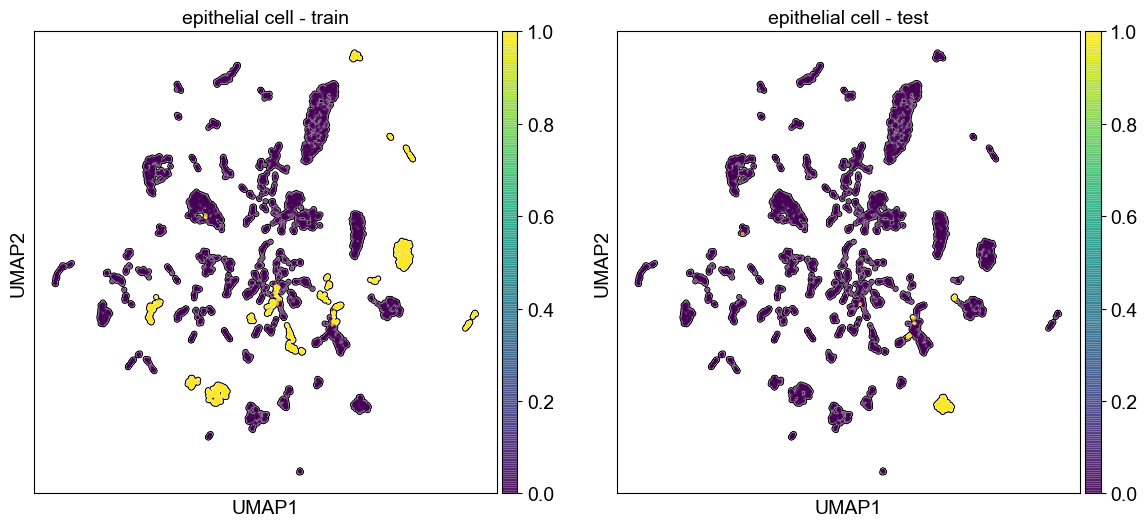

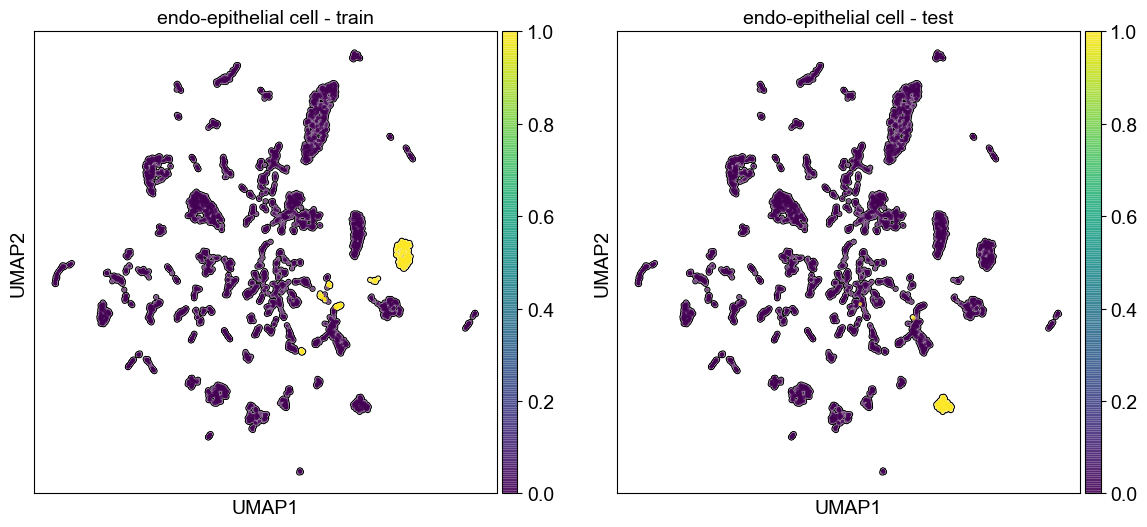

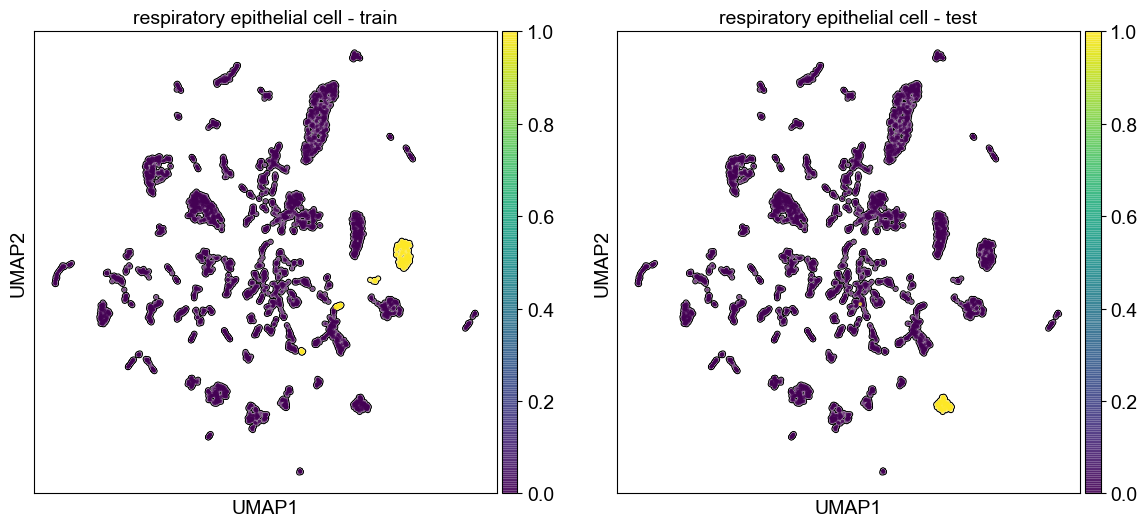

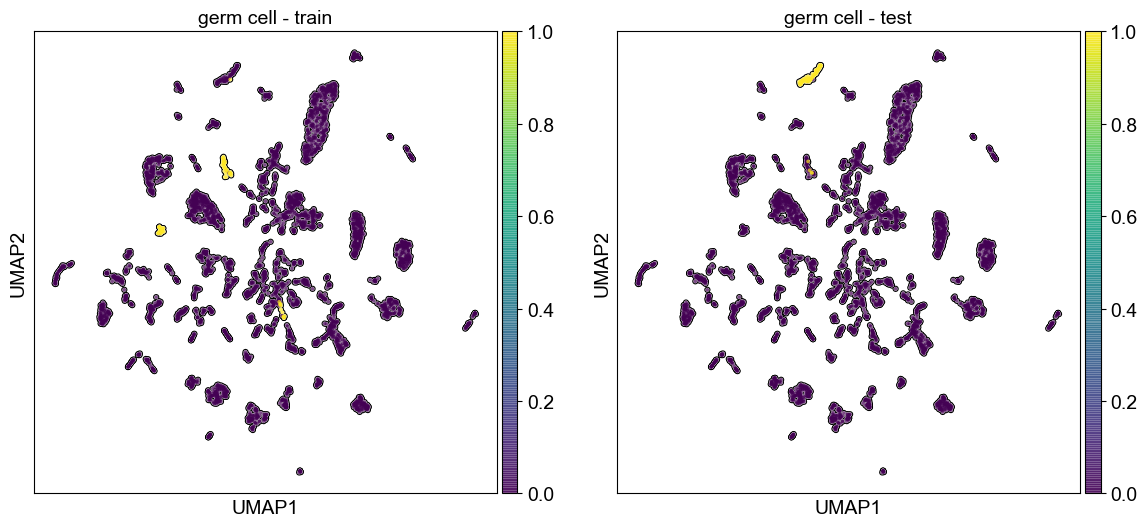

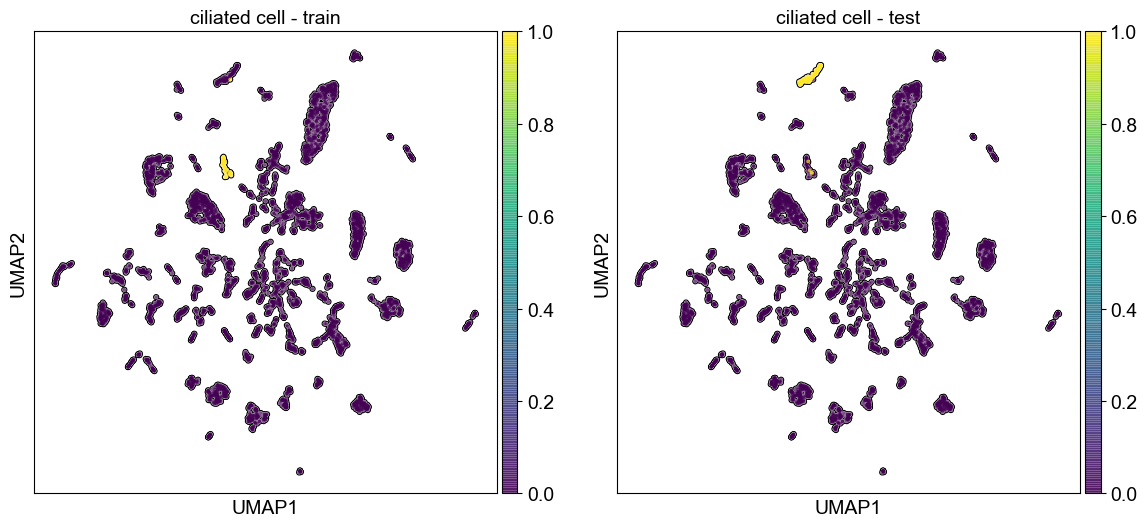

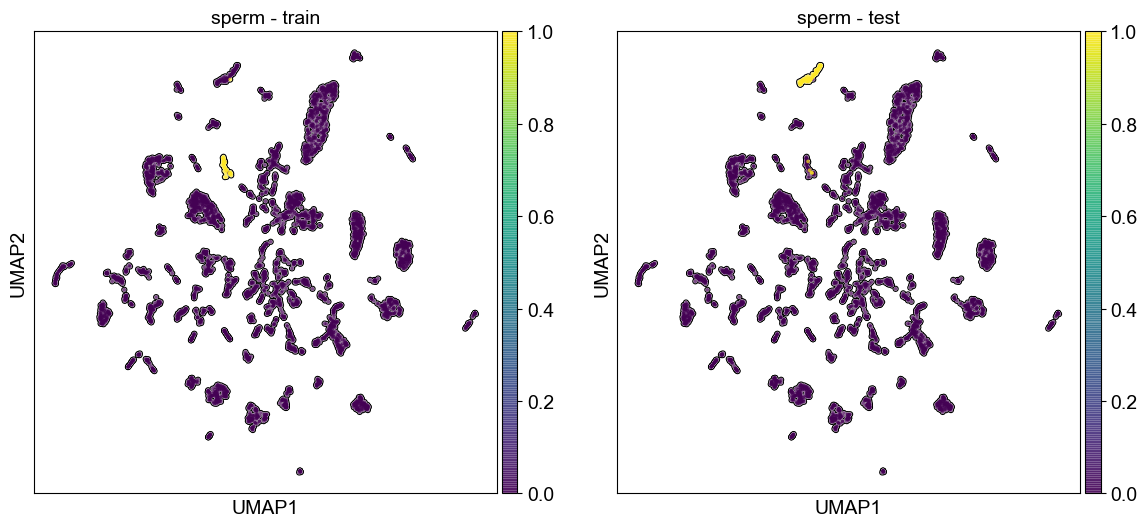

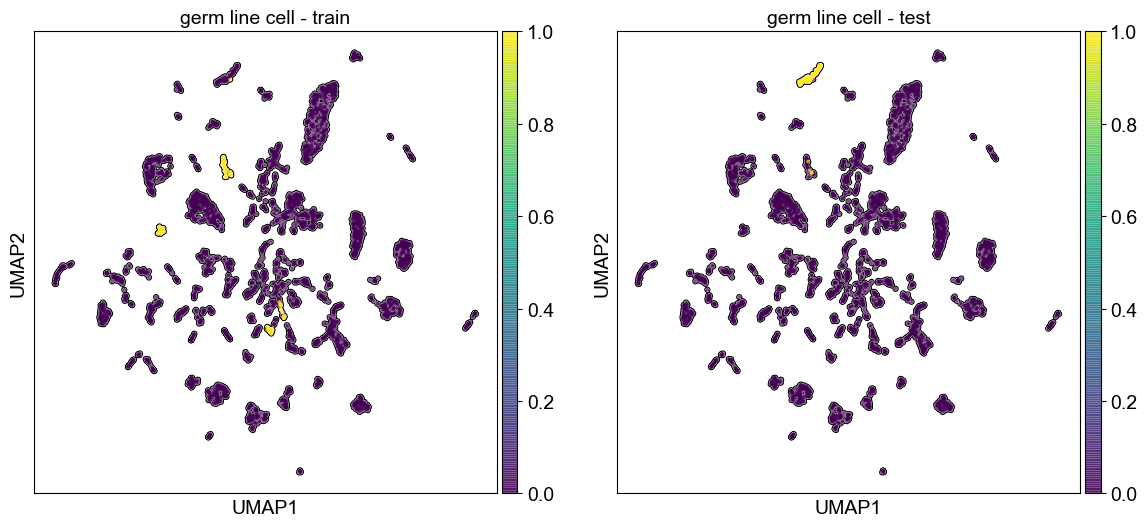

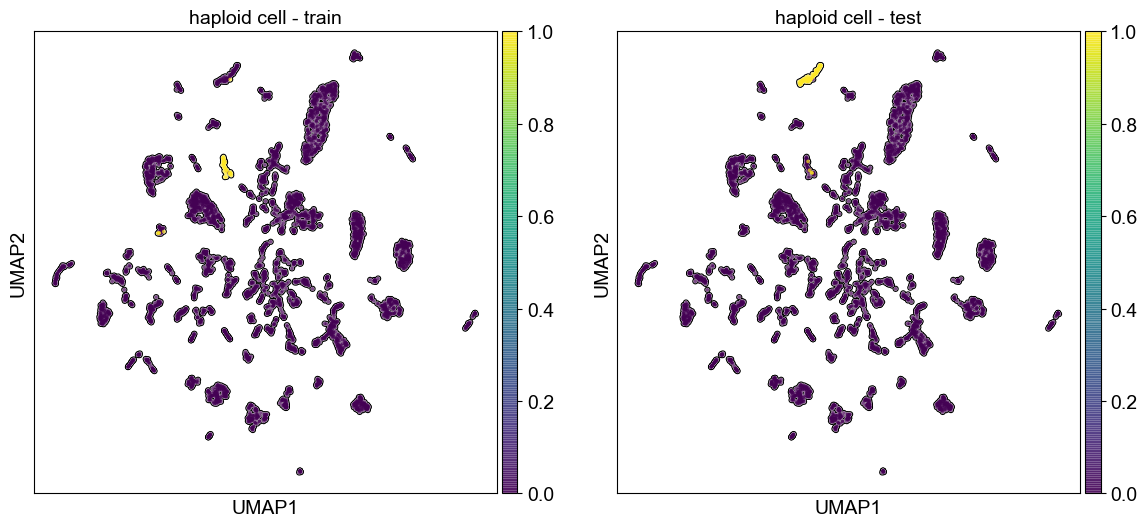

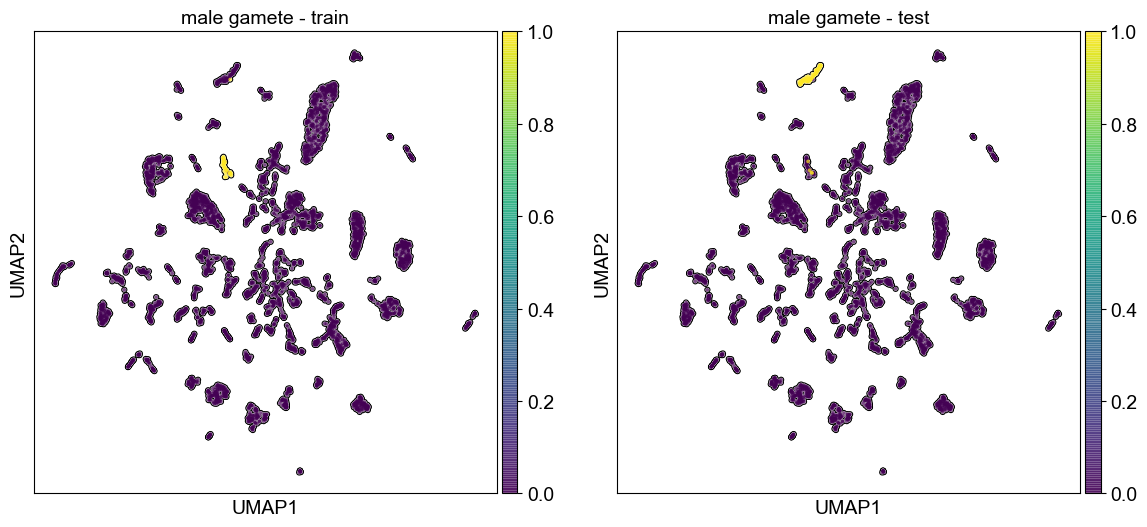

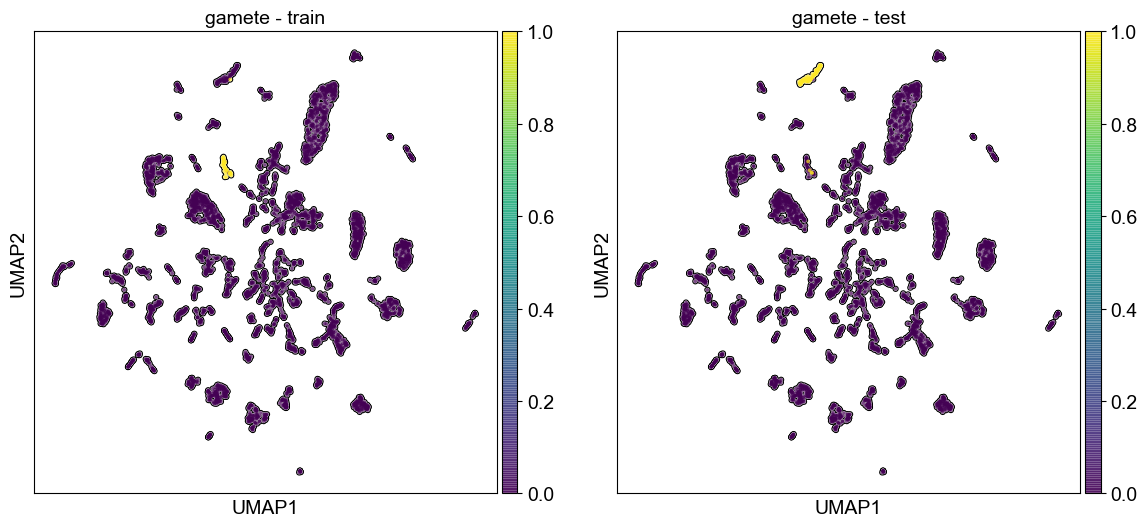

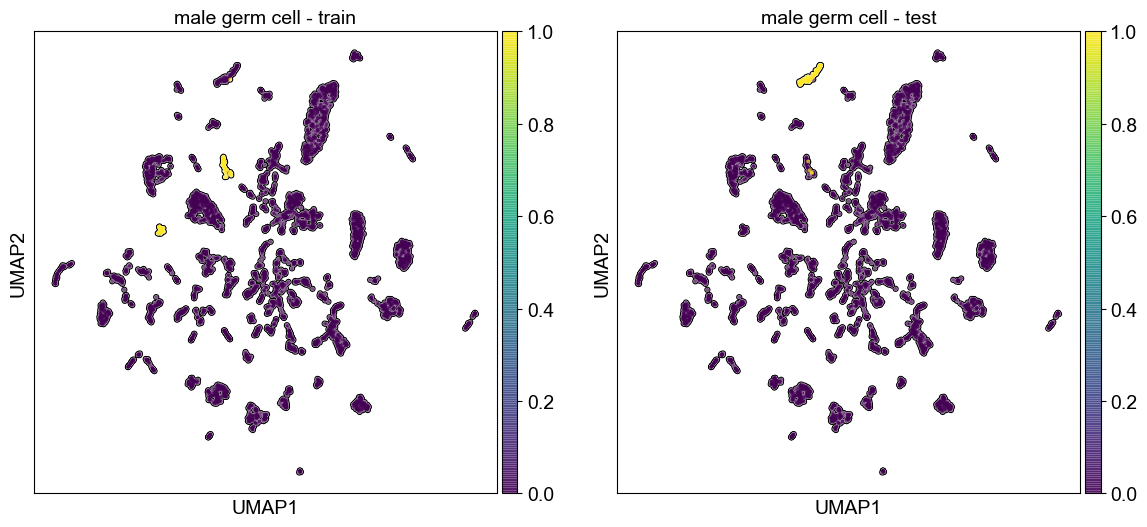

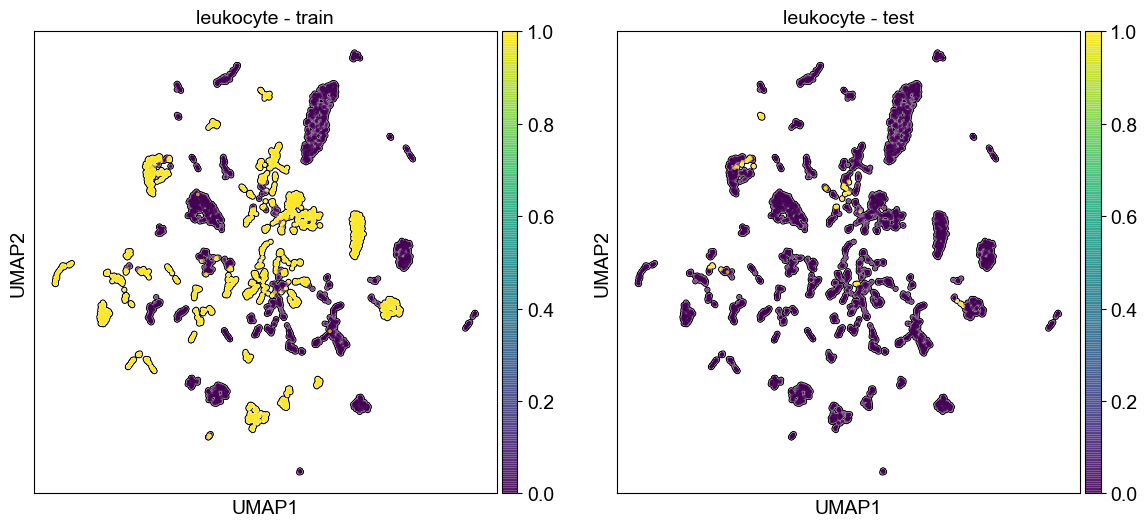

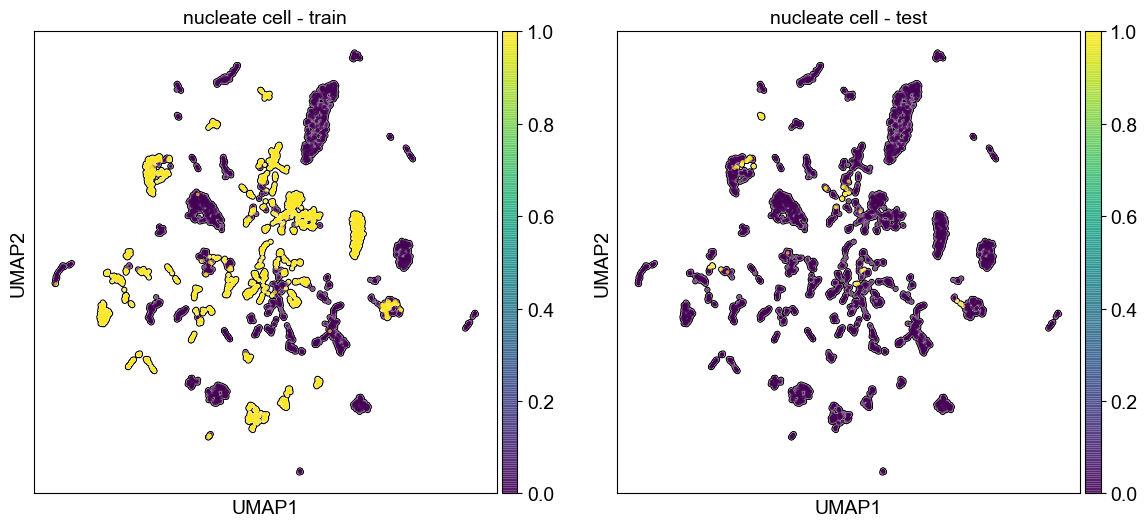

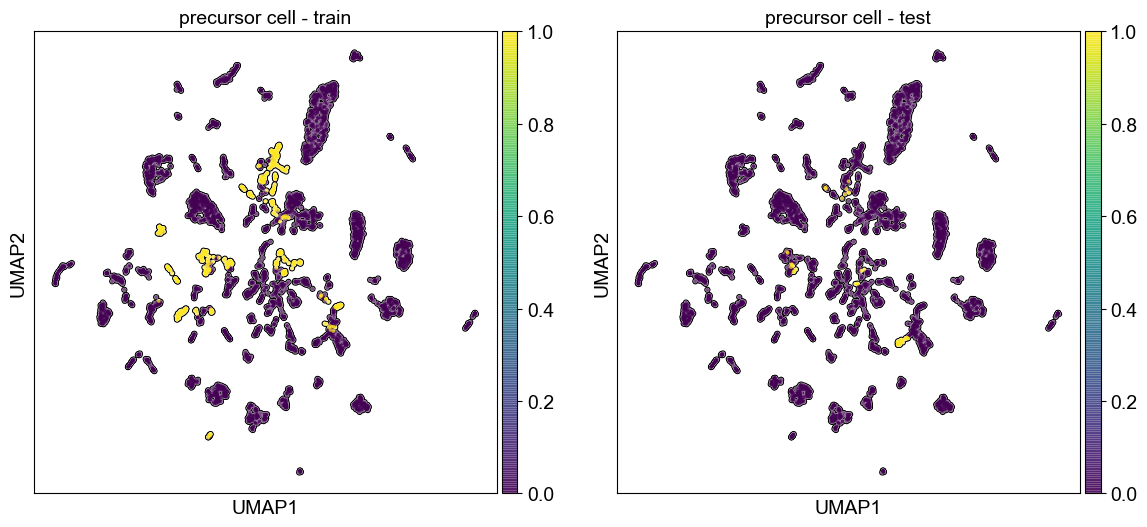

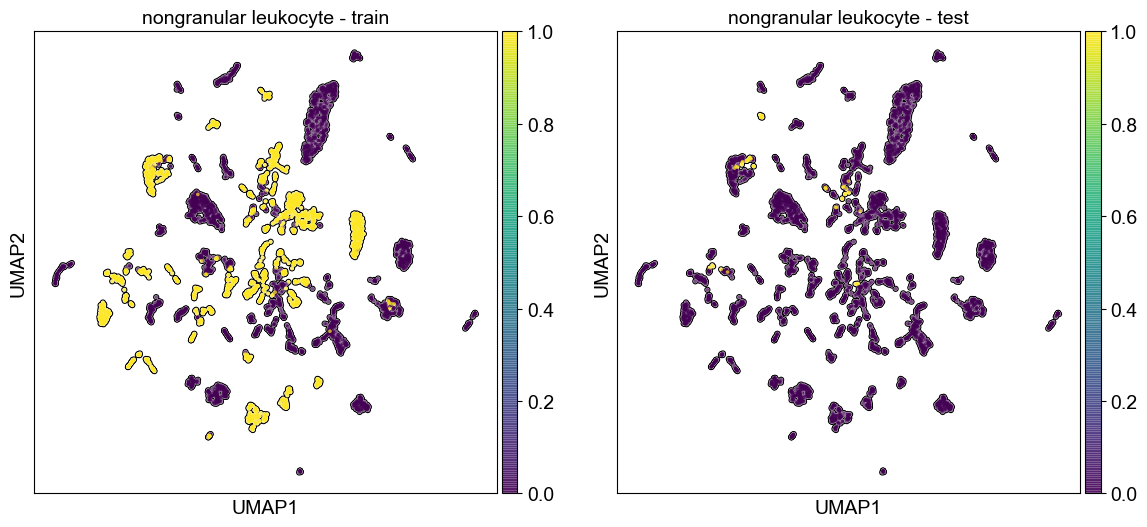

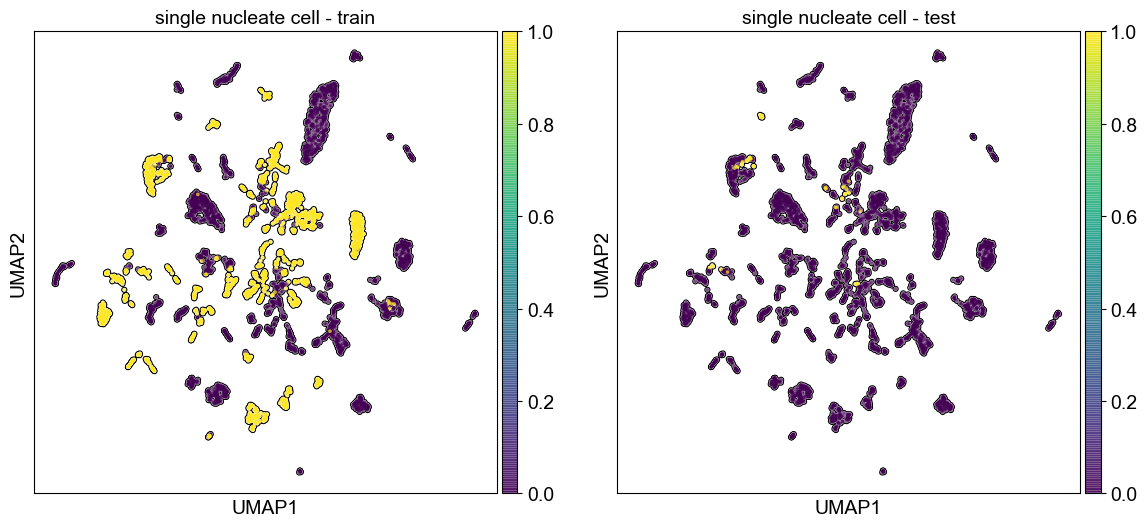

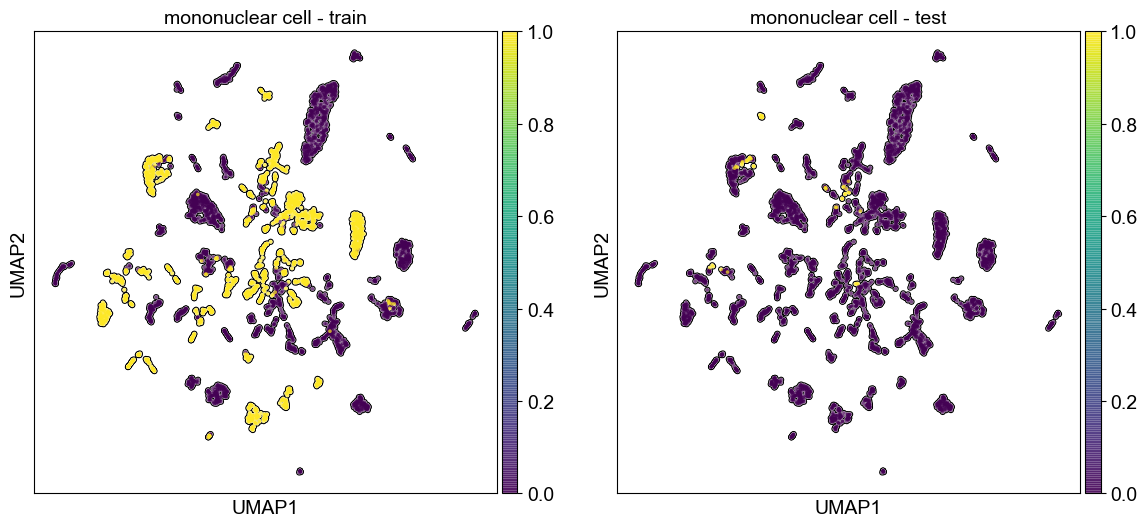

In [187]:
sc.set_figure_params(dpi=100)
plt.rcParams["figure.figsize"] = (6, 6)

for ctype in top_train_types.index:
    sc.pl.umap(ad, color=[ctype + ' - train', ctype + ' - test'], add_outline=True)